# NeuralOperator + Physics on PytorchLightening on Turbulent Data

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from turboflow.dataloaders import PatchDataModule

from turboflow.models import RFFNet_pl, FNONet_pl


np.random.seed(666)

torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0


## Input data

Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


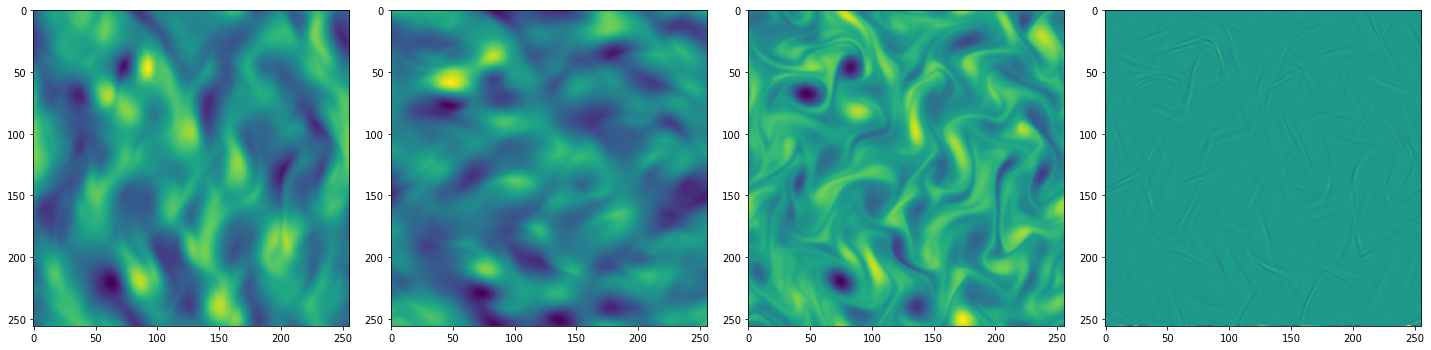

In [2]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)
img_index = 42
X = IMGs[img_index,:,:,:2] / 255
U = IMGs[img_index,:,:,2]
V = IMGs[img_index,:,:,3]
t = np.arange(0,IMGs.shape[0],step=0.01)
Re = 3900

W = phy.compute_vorticity(U,V)
D = phy.compute_divergence(U,V)

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(U)
plt.subplot(142)
plt.imshow(V)
plt.subplot(143)
plt.imshow(W)
plt.subplot(144)
plt.imshow(D)
plt.tight_layout()
plt.show()

In [3]:
# img_index = 1
# X1, X2 = IMGs[img_index,:,:,0], IMGs[img_index+1,:,:,0]
# Y1, Y2 = IMGs[img_index,:,:,1], IMGs[img_index+1,:,:,1]
# U1, U2 = IMGs[img_index,:,:,2], IMGs[img_index+1,:,:,2]
# V1, V2 = IMGs[img_index,:,:,3], IMGs[img_index+1,:,:,3]
# W1 = phy.compute_vorticity(U1, V1)
# W2 = phy.compute_vorticity(U2, V2)
# D1 = phy.compute_divergence(U1, V1)
# D2 = phy.compute_divergence(U2, V2)

In [4]:
img_index = 30

# normalize output
y = IMGs[img_index,:,:,2:4]
print('Y shape', y.shape)
print('Y min, max:', np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print('after normalization, Y min, max:', np.min(y), np.max(y))

assert np.max(np.abs(y)) <= 1.0
assert np.max(np.abs(X)) >= 0
assert np.max(np.abs(X)) <= 1.0

Y shape (256, 256, 2)
Y min, max: -2.513101 3.217103
after normalization, Y min, max: -0.7811689585319462 1.0


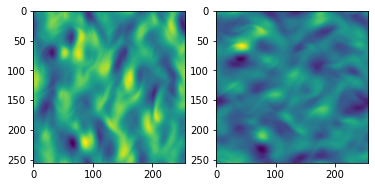

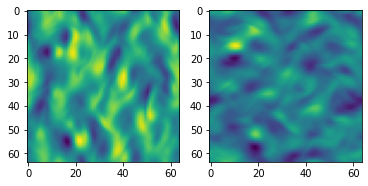

No handles with labels found to put in legend.


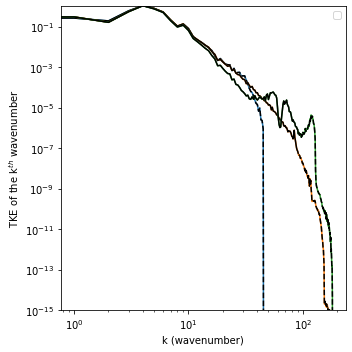

In [5]:
Xtest = X
ytest = y

# downsampled resultion
scale = 1/4
X1ds = dsp.interpolate2D(X, X[:,:,0], scale=scale)[:,:,None]
X2ds = dsp.interpolate2D(X, X[:,:,1], scale=scale)[:,:,None]
y1ds = dsp.interpolate2D(X, y[:,:,0], scale=scale)[:,:,None]
y2ds = dsp.interpolate2D(X, y[:,:,1], scale=scale)[:,:,None]

Xtrain = np.concatenate([X1ds, X2ds], axis=-1)
ytrain = np.concatenate([y1ds, y2ds], axis=-1)

fig, axs = plt.subplots(1,2)
axs[0].imshow(ytest[:,:,0])
axs[1].imshow(ytest[:,:,1])
plt.show()

fig, axs = plt.subplots(1,2)
axs[0].imshow(ytrain[:,:,0])
axs[1].imshow(ytrain[:,:,1])
plt.show()

# upsampled resolution
yup = dsp.interpolate2D(Xtrain, ytrain[:,:,0], scale=4)[:,:,None]

fig, axs = plt.subplots(1,1,figsize=(5,5))
phy.plot_energy_spec(phy.powerspec(ytrain[:,:,0]), axs, label='U train')
phy.plot_energy_spec(phy.powerspec(ytest[:,:,0]), axs, label='U test')
phy.plot_energy_spec(phy.powerspec(yup[:,:,0]), axs, label='U test')
axs.set_ylim(10**(-15), 1)
plt.legend()
plt.tight_layout()
plt.show()

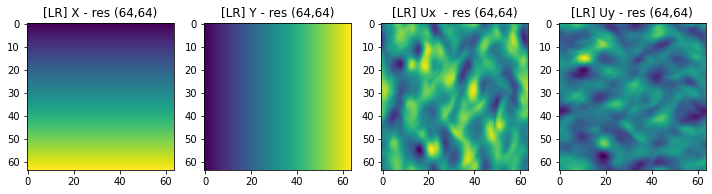

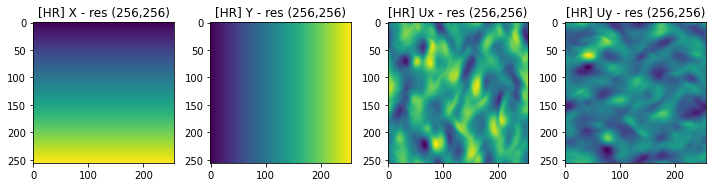

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(141)
plt.title('[LR] X - res (%d,%d)' % Xtrain[:,:,0].shape)
plt.imshow(Xtrain[:,:,0])
plt.subplot(142)
plt.title('[LR] Y - res (%d,%d)' % Xtrain[:,:,1].shape)
plt.imshow(Xtrain[:,:,1])
plt.subplot(143)
plt.title('[LR] Ux  - res (%d,%d)' % ytrain[:,:,0].shape)
plt.imshow(ytrain[:,:,0])
plt.subplot(144)
plt.title('[LR] Uy - res (%d,%d)' % ytrain[:,:,1].shape)
plt.imshow(ytrain[:,:,1])
plt.tight_layout()
plt.savefig('../figures/turboflow_train.pdf', dpi=150)
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(141)
plt.title('[HR] X - res (%d,%d)' % Xtest[:,:,0].shape)
plt.imshow(Xtest[:,:,0])
plt.subplot(142)
plt.title('[HR] Y - res (%d,%d)' % Xtest[:,:,1].shape)
plt.imshow(Xtest[:,:,1])
plt.subplot(143)
plt.title('[HR] Ux - res (%d,%d)' % ytest[:,:,0].shape)
plt.imshow(ytest[:,:,0])
plt.subplot(144)
plt.title('[HR] Uy - res (%d,%d)' % ytest[:,:,1].shape)
plt.imshow(ytest[:,:,1])
plt.tight_layout()
plt.savefig('../figures/turboflow_test.pdf', dpi=150)
plt.show()

## LEARNING TURBULENCES based on Patches

In [114]:
from sklearn.feature_extraction.image import extract_patches_2d

def extract_patches(x, sizes):
    patches = []
    for size in sizes:
        patches_np = extract_patches_2d(Xtrain, size) #.transpose((0,3,1,2))
        print(patches_np.shape)
        for b in range(patches_np.shape[0]):
            patches.append(patches_np[b,...])
    return patches

XtrainPatch = extract_patches(Xtrain, [(32,32)])        
ytrainPatch = extract_patches(ytrain, [(32,32)])
XtestPatch = extract_patches(Xtest,   [(32,32)]) 
ytestPatch = extract_patches(ytest,   [(32,32)])

(1089, 32, 32, 2)
(1089, 32, 32, 2)
(1089, 32, 32, 2)
(1089, 32, 32, 2)


In [115]:
dm_dict = {}
dm_dict['PatchFNO'] = PatchDataModule(
    train_data=[XtrainPatch, ytrainPatch],
    val_data=[XtrainPatch, ytrainPatch],
    test_data=[XtestPatch, ytestPatch],
    batch_size = 128,
)

In [116]:
# test data loader
dm_dict['PatchFNO'].prepare_data()
for batch in dm_dict['PatchFNO'].val_dataloader():
    X, y = batch
    print(X.shape)
    print(y.shape)
    break

torch.Size([128, 32, 32, 2])
torch.Size([128, 32, 32, 2])


In [117]:
model_dict = {}

In [121]:
max_iters = int(10e3)

modes = 12
width = 32
lam_pde = 0
model = FNONet_pl(modes, modes, width, lam_pde=lam_pde)
model_dict['PatchFNO'] = model
early_stop_callback = EarlyStopping(monitor='valid_loss')

In [123]:
trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=12, 
                     max_epochs=max_iters, 
                     callbacks=[early_stop_callback])

trainer.fit(model_dict['PatchFNO'], dm_dict['PatchFNO'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type  | Params
----------------------------------
0 | network | FNO2d | 1.2 M 
----------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.754     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

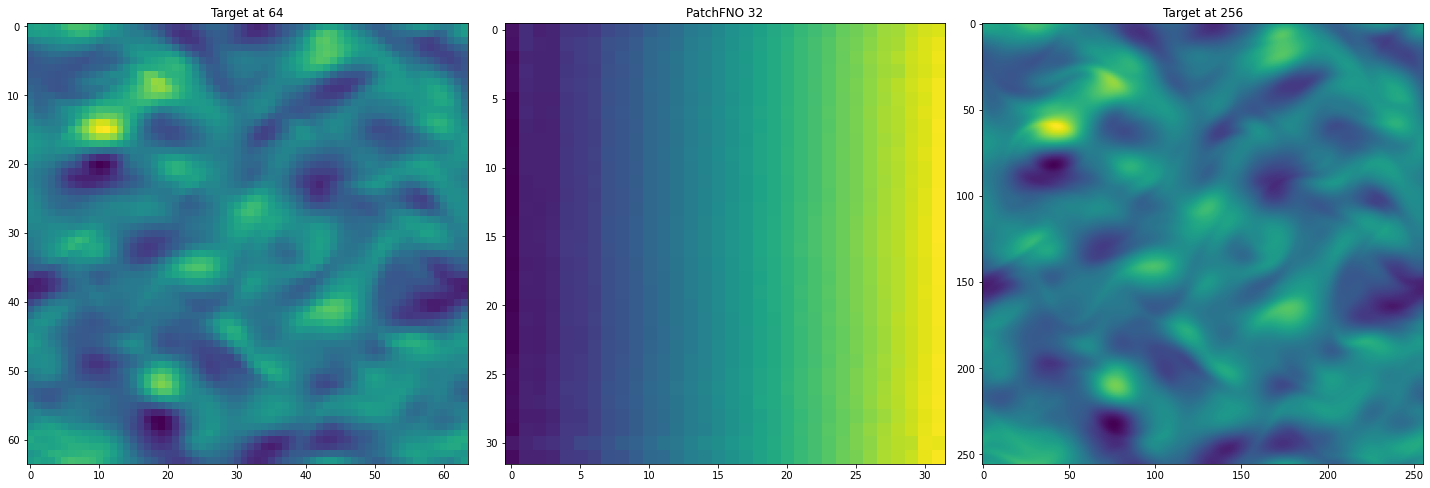

In [129]:
def my_pred(ngrid, model):
    model.eval().to(device)
    coords = np.linspace(0, 1, ngrid, endpoint=False)
    coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
    tmp = coords[:,:,0].copy()
    coords[:,:,0] = coords[:,:,1]
    coords[:,:,1] = tmp
    pred = model(torch.from_numpy(coords).float().to(device)[None,...])
    ypred = pred.cpu().detach().numpy().squeeze()
    return ypred

for res in [32]:

    FNOpred = my_pred(res, model_dict['PatchFNO'])
    
    figsize = (20,20)
    fig, axs = plt.subplots(1,3, figsize=figsize)
    axs[0].imshow(ytrain[:,:,1].squeeze())
    axs[0].set_title('Target at %d' % 64)
    axs[1].imshow(FNOpred[:,:,1])
    axs[1].set_title('PatchFNO %d' % res)
    axs[2].imshow(ytest[:,:,1].squeeze())
    axs[2].set_title('Target at %d' % 256)
    plt.tight_layout()
    plt.show()

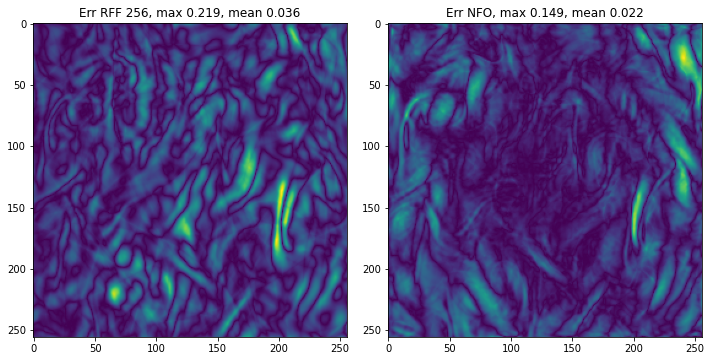

In [14]:
FNOpred = my_pred(256, model_dict['FNO'])
RFFpred = my_pred(256, model_dict['RFF'])

figsize = (10,10)
fig, axs = plt.subplots(1,2, figsize=figsize)
errRFF = np.abs(ytest[:,:,0].squeeze() - RFFpred[:,:,0])
errNFO = np.abs(ytest[:,:,0].squeeze() - FNOpred[:,:,0])
axs[0].imshow(errRFF)
axs[0].set_title('Err RFF 256, max %1.3f, mean %1.3f' % (np.max(errRFF), np.mean(errRFF)))
axs[1].imshow(errNFO)
axs[1].set_title('Err NFO, max %1.3f, mean %1.3f' % (np.max(errNFO), np.mean(errNFO)))
plt.tight_layout()
plt.show()

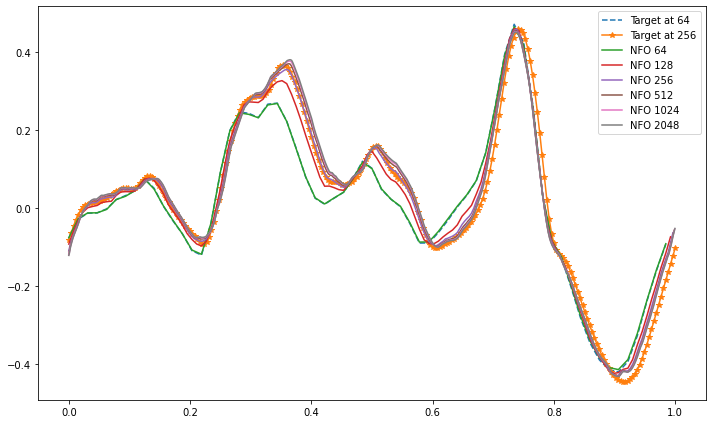

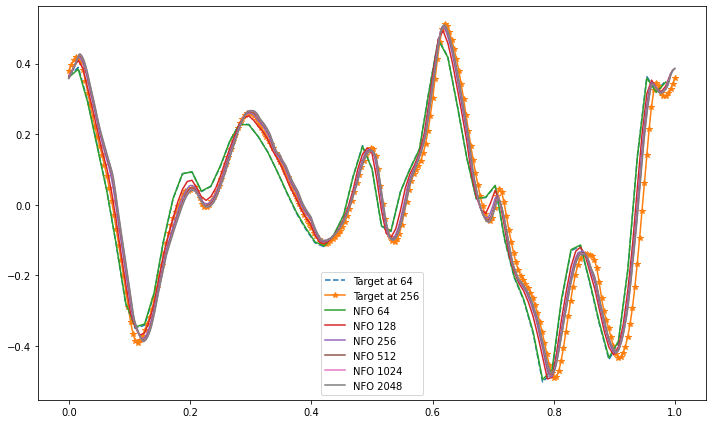

In [20]:
figsize = (10,6)
fig, axs = plt.subplots(1,1, figsize=figsize)
plt.plot(np.linspace(0,1-1/64,64), ytrain[:,32,0].squeeze(), '--', label='Target at %d' % 64)
plt.plot(np.linspace(0,1,256), ytest[:,128,0].squeeze(), '-*', label='Target at %d' % 256)

for res in [64, 128, 256, 512, 1024, 2048]:
    FNOpred = my_pred(res, model_dict['FNO'])
    plt.plot(np.linspace(0,1-1/res,res), FNOpred[:,int(res//2),0].squeeze(), label='NFO %d' % res)

plt.legend()
plt.tight_layout()
plt.show()

figsize = (10,6)
fig, axs = plt.subplots(1,1, figsize=figsize)
plt.plot(np.linspace(0,1-1/64,64), ytrain[32,:,0].squeeze(), '--', label='Target at %d' % 64)
plt.plot(np.linspace(0,1,256), ytest[128,:,0].squeeze(), '-*', label='Target at %d' % 256)

for res in [64, 128, 256, 512, 1024, 2048]:
    FNOpred = my_pred(res, model_dict['FNO'])
    plt.plot(np.linspace(0,1-1/res,res), FNOpred[int(res//2),:,0].squeeze(), label='NFO %d' % res)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
Npred256 = my_pred(256, model_dict['None'])
Npred256ph = my_pred(256, model_dict['NonePh'])
Fpred256 = my_pred(256, model_dict['Fourier10'])
Fpred256ph = my_pred(256, model_dict['Fourier10Ph'])
Ipred256 = my_intr(256,Xtrain, ytrain)
Npred512 = my_pred(512, model_dict['None'])
Fpred512 = my_pred(512, model_dict['Fourier10'])
Npred512Ph = my_pred(512, model_dict['NonePh'])
Fpred512Ph = my_pred(512, model_dict['Fourier10Ph'])
Ipred512 = my_intr(512,Xtrain, ytrain)

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_PHY.pdf', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
# plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
# plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
# plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
# plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_TGT.pdf', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
# plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
# plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_INT.pdf', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
# plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_NONE.pdf', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_RFF.pdf', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
# plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_PHY.pdf', dpi=300)
plt.show()